<a href="https://colab.research.google.com/github/muke888/Personal-Projects/blob/master/FashionImageSearch/Prototyping_Fashion_CNN_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A quick prototyping session for fashion reverse search - Part 1 
- Extracting features using a pretrained model & saving features and mappings

In [1]:
!pip install tf-nightly -q
!pip install annoy -q
!pip3 install faiss -q
!sudo apt-get install libopenblas-dev
!sudo apt-get install libomp-dev

!pip install gdown -q
import gdown
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import random, collections, json
#from tensorflow.keras.preprocessing import image_dataset_from_directory
gdown.download('https://drive.google.com/uc?id=1MQNp4IbRuWs2E-fyU0009y_fgBxLBHXc','Train Directory.zip',quiet=False)  #Downloading 173mb fashion dataset sourced from kaggle https://www.kaggle.com/abhishekm6/fashion-dataset

     |████████████████████████████████| 390.1MB 38kB/s 
     |████████████████████████████████| 10.1MB 37.0MB/s 
     |████████████████████████████████| 460kB 43.1MB/s 
     |████████████████████████████████| 645kB 4.9MB/s 
     |████████████████████████████████| 4.7MB 5.0MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenblas-dev is already the newest version (0.2.20+ds-4).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages w

Downloading...
From: https://drive.google.com/uc?id=1MQNp4IbRuWs2E-fyU0009y_fgBxLBHXc
To: /content/Train Directory.zip
173MB [00:01, 99.0MB/s]


'Train Directory.zip'

In [2]:
# Using helper function to get image paths for keras image loader

#https://stackoverflow.com/questions/62166588/how-to-obtain-filenames-during-prediction-while-using-tf-keras-preprocessing-ima
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing
from tensorflow.python.keras.preprocessing import dataset_utils
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.util.tf_export import keras_export

WHITELIST_FORMATS = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

## Tensorflow override method to return fname as list as well as dataset

def image_dataset_from_directory(directory,
                                 labels='inferred',
                                 label_mode='int',
                                 class_names=None,
                                 color_mode='rgb',
                                 batch_size=32,
                                 image_size=(256, 256),
                                 shuffle=True,
                                 seed=None,
                                 validation_split=None,
                                 subset=None,
                                 interpolation='bilinear',
                                 follow_links=False):
  
  if labels != 'inferred':
    if not isinstance(labels, (list, tuple)):
      raise ValueError(
          '`labels` argument should be a list/tuple of integer labels, of '
          'the same size as the number of image files in the target '
          'directory. If you wish to infer the labels from the subdirectory '
          'names in the target directory, pass `labels="inferred"`. '
          'If you wish to get a dataset that only contains images '
          '(no labels), pass `label_mode=None`.')
    if class_names:
      raise ValueError('You can only pass `class_names` if the labels are '
                       'inferred from the subdirectory names in the target '
                       'directory (`labels="inferred"`).')
  if label_mode not in {'int', 'categorical', 'binary', None}:
    raise ValueError(
        '`label_mode` argument must be one of "int", "categorical", "binary", '
        'or None. Received: %s' % (label_mode,))
  if color_mode == 'rgb':
    num_channels = 3
  elif color_mode == 'rgba':
    num_channels = 4
  elif color_mode == 'grayscale':
    num_channels = 1
  else:
    raise ValueError(
        '`color_mode` must be one of {"rbg", "rgba", "grayscale"}. '
        'Received: %s' % (color_mode,))
  interpolation = image_preprocessing.get_interpolation(interpolation)
  dataset_utils.check_validation_split_arg(
      validation_split, subset, shuffle, seed)

  if seed is None:
    seed = np.random.randint(1e6)
  image_paths, labels, class_names = dataset_utils.index_directory(
      directory,
      labels,
      formats=WHITELIST_FORMATS,
      class_names=class_names,
      shuffle=shuffle,
      seed=seed,
      follow_links=follow_links)

  if label_mode == 'binary' and len(class_names) != 2:
    raise ValueError(
        'When passing `label_mode="binary", there must exactly 2 classes. '
        'Found the following classes: %s' % (class_names,))

  image_paths, labels = dataset_utils.get_training_or_validation_split(
      image_paths, labels, validation_split, subset)

  dataset = paths_and_labels_to_dataset(
      image_paths=image_paths,
      image_size=image_size,
      num_channels=num_channels,
      labels=labels,
      label_mode=label_mode,
      num_classes=len(class_names),
      interpolation=interpolation)
  if shuffle:
    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
  dataset = dataset.batch(batch_size)
  # Users may need to reference `class_names`.
  dataset.class_names = class_names
  return dataset, image_paths

def paths_and_labels_to_dataset(image_paths,
                                image_size,
                                num_channels,
                                labels,
                                label_mode,
                                num_classes,
                                interpolation):
  """Constructs a dataset of images and labels."""
  # TODO(fchollet): consider making num_parallel_calls settable
  path_ds = dataset_ops.Dataset.from_tensor_slices(image_paths)
  img_ds = path_ds.map(
      lambda x: path_to_image(x, image_size, num_channels, interpolation))
  if label_mode:
    label_ds = dataset_utils.labels_to_dataset(labels, label_mode, num_classes)
    img_ds = dataset_ops.Dataset.zip((img_ds, label_ds))
  return img_ds


def path_to_image(path, image_size, num_channels, interpolation):
  img = io_ops.read_file(path)
  img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
  img = image_ops.resize_images_v2(img, image_size, method=interpolation)
  img.set_shape((image_size[0], image_size[1], num_channels))
  return img

In [3]:
# Extract Zipped dataset
import zipfile
with zipfile.ZipFile("Train Directory.zip","r") as zip_ref:
    zip_ref.extractall("fashion")

In [4]:
# Loading dataset
train_dir = '/content/fashion/Train Directory'
BATCH_SIZE = 1
#IMG_SIZE = (224, 224)
IMG_SIZE = (331, 331)
image_dataset, image_paths = image_dataset_from_directory(train_dir,
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3370 files belonging to 12 classes.


In [5]:
# Check first 5 image paths
image_paths[:5]

['/content/fashion/Train Directory/Checked/66245.jpg',
 '/content/fashion/Train Directory/Checked/66251.jpg',
 '/content/fashion/Train Directory/Checked/66252.jpg',
 '/content/fashion/Train Directory/Checked/66253.jpg',
 '/content/fashion/Train Directory/Checked/66254.jpg']

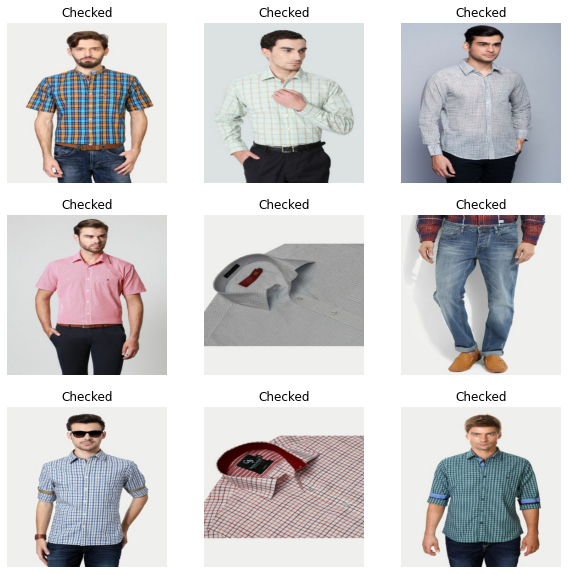

In [6]:
#A glance at the images
class_names = image_dataset.class_names

plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(image_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.squeeze(images, axis=0).astype("uint8"))
  plt.title(class_names[labels[0]])
  plt.axis("off")

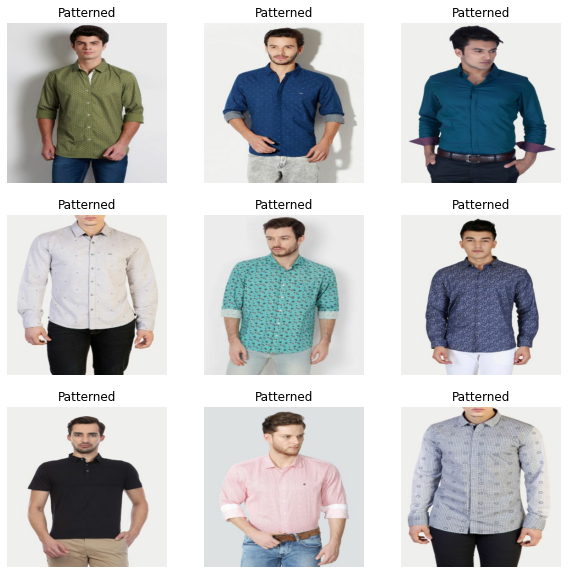

In [8]:
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(image_dataset.skip(888).take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.squeeze(images, axis=0).astype("uint8"))
  plt.title(class_names[labels[0]])
  plt.axis("off")

In [ ]:
#Helper to prefetch data dynamically if we are dealing with a large dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE

image_dataset = image_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Create the base model from the pre-trained model 'NASNet-Large', the best available pre-trained model in keras
IMG_SHAPE = IMG_SIZE + (3,)
pretrained_NASNET = tf.keras.applications.NASNetLarge(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

pretrained_NASNET.summary()

359751680/359748576 [==============================] - 3s 0us/step
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
__________________________

In [10]:
#Get last layer before prediction where we get output (None, 4032) for feature extraction
from keras.models import Model
model = Model(inputs=pretrained_NASNET.input,
                  outputs=pretrained_NASNET.get_layer('global_average_pooling2d').output)

In [ ]:
#Convert all images to features, and create 'mapping' file index

import collections, json
mapping = collections.OrderedDict()
#resized_imgs = np.zeros(shape=(len(image_paths), 331, 331, 3)) # Optional to store resized images in matrix form
features= np.zeros(shape=(len(image_paths), 4032))

for i, (images, labels) in enumerate(image_dataset):
  mapping[i]=[class_names[labels[0]],image_paths[i]]
  #resized_imgs[i, :, :, :] = images.numpy()
  input = tf.keras.applications.nasnet.preprocess_input(images)
  features[i,:] = model.predict(input)
  print(i)


In [ ]:
print(mapping[0], features.shape)

In [ ]:
#Saving features & mapping file_index to disc
np.save('saved_features_NasNet.npy', features)
with open('file_index_NasNet.json', 'w') as index_file:
  json.dump(mapping, index_file)

In [11]:
#Loading features & mapping file_index from disc
import collections, json

features = np.load('saved_features_NasNet.npy')
with open('file_index_NasNet.json') as json_file:
    mapping = json.load(json_file)
    mapping = {int(k): v for k, v in mapping.items()}
    

print(mapping[0], features.shape)

['Checked', '/content/fashion/Train Directory/Checked/66245.jpg'] (3370, 4032)


## A quick prototyping for fashion reverse search - Part 2 
- Using features to do 'nearest neighbors search'  via Annoy (Spotify) & Faiss (Facebook) C++ libraries
- 'Approximate Nearest Neighbors' search for large datasets where speed is preferrable over accuracy
- Benefits of being able to save and share index across systems

In [13]:
#Annoy indexing method - Approximate Nearest Neighbors

annoy_index = annoy.AnnoyIndex(4032, metric='angular')
for i, row in enumerate(features):
  vec = row
  annoy_index.add_item(i, vec)
annoy_index.build(1000)  #No. of trees, higher more accurate but slower

True

In [ ]:
#Saving the annoy index
annoy_index.save('feature_index.ann')
#Loading the annoy index
annoy_index = AnnoyIndex(4032, metric='angular')
annoy_index.load('feature_index.ann')

In [14]:
def quick_search_annoy(item, feature_index, mapping, top_n=10):
  #result = feature_index.get_nns_by_item(item, top_n, include_distances=True) #search within the feature index by key
  result = feature_index.get_nns_by_vector(item, top_n, include_distances=True)
  plt.figure(figsize=(15, 15))
  for i in range(10):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(tf.keras.preprocessing.image.load_img(mapping[result[0][i]][1],target_size=None))
    plt.title(mapping[result[0][i]][0]+' - score:'+str(round(result[1][i],2)))
    plt.axis("off")

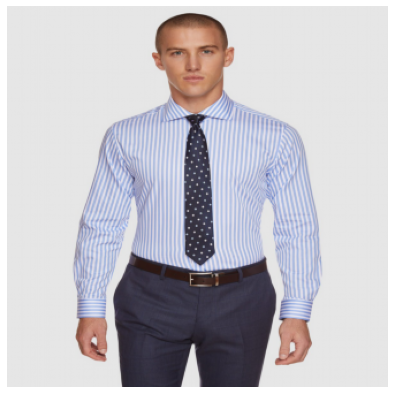

In [15]:
import skimage.io
import skimage.transform
from keras.preprocessing.image import array_to_img

#URL = "https://cdn.shopify.com/s/files/1/0045/7349/5389/products/white-tintins-aussie-adventures-mens-tshirt_1800x1800.jpg"
#URL= "https://myer-media.com.au/wcsstore/MyerCatalogAssetStore/images/40/400/3311/10/1/159757840/159757840_1_720x928.jpg"
URL= "https://cdn.shopify.com/s/files/1/0120/0311/5089/products/PR9541.0101_1_1200x.jpg"

image_numpy = skimage.io.imread(URL)
resized=skimage.transform.resize(image_numpy,(331, 331,3))
pil=array_to_img(resized)
#pil=tf.keras.preprocessing.image.load_img("test.jpg",target_size=(331, 331,3))      #Use this instead if loading local image from disc
input = tf.keras.applications.nasnet.preprocess_input(np.expand_dims(pil,axis=0))
test_feat=model.predict(input)
plt.figure(figsize=(7, 7))
plt.imshow(resized)
plt.axis("off")
plt.show()

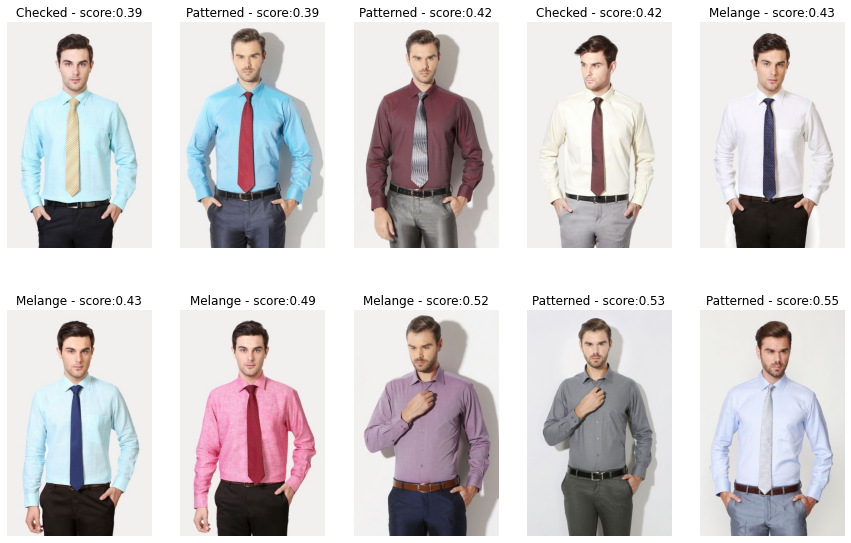

In [17]:
#Let's search similiar images in annoy_index to the above URL image

quick_search_annoy(np.squeeze(test_feat),annoy_index, mapping)

In [18]:
## Faiss method - we will use exact search in this example as dataset is small##

#Useful links
#https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index
#https://github.com/matsui528/faiss_tips

#Faiss requires float32, so we ensure that our features are in the correct format

features=features.astype(np.float32)
features.dtype

dtype('float32')

In [19]:
#L2 Faiss flat indexing method - Euclidian distance with no compression

import faiss
faiss_index = faiss.IndexFlatL2(4032)
#faiss_index= faiss.IndexFlatIP(4032)    #Optional: Inner Product --> Cosine/angular
print(faiss_index.is_trained)
#faiss.normalize_L2(features)            #Need if Cosine/angular 
faiss_index.add(features)
print(faiss_index.ntotal)

True
3370


In [20]:
def quick_search_faiss(item, faiss_index, mapping, top_n=10):
  D, I = faiss_index.search(np.expand_dims(features[item],axis=0),top_n)
  plt.figure(figsize=(15, 15))
  for i in range(10):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(tf.keras.preprocessing.image.load_img(mapping[I[0][i]][1],target_size=None))
    plt.title(mapping[I[0][i]][0]+' - score:'+str(round(D[0][i],2)))
    plt.axis("off")

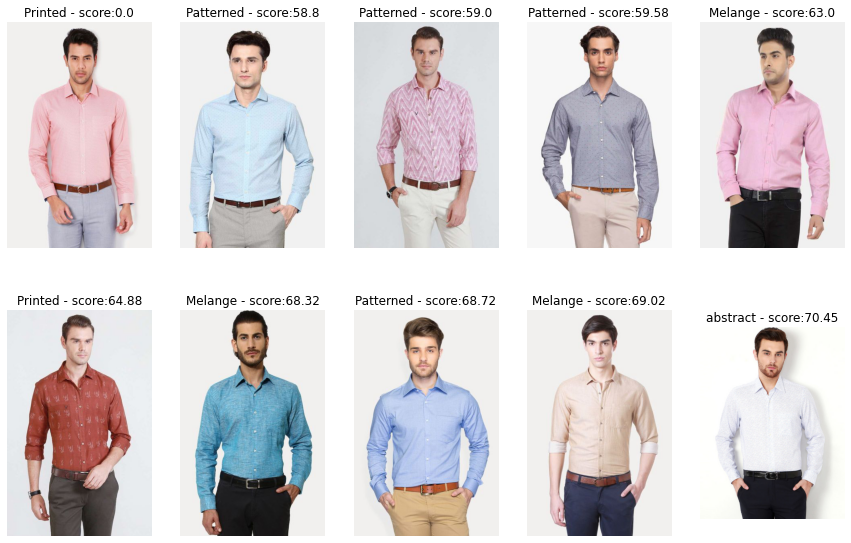

In [21]:
# Random quick search within the index
x = random.randint(0,(len(mapping)-1))
quick_search_faiss(500,faiss_index, mapping)

In [23]:
#Faiss URL search function for top 9 similiar images

def URL_search_faiss(URL, faiss_index, mapping, top_n=9):
  image_numpy= skimage.io.imread(URL)
  resized=skimage.transform.resize(image_numpy,(331, 331,3))
  pil=array_to_img(resized)
  input = tf.keras.applications.nasnet.preprocess_input(np.expand_dims(pil,axis=0))
  feature=model.predict(input)
  #faiss.normalize_L2(feature)         #Need if Cosine/angular 
  D, I = faiss_index.search(feature,top_n)
  plt.figure(figsize=(15, 15))
  ax = plt.subplot(3, 5, 1)
  plt.imshow(image_numpy)
  plt.axis("off")
  plt.title("URL image to match")
  for i in range(9):
    ax = plt.subplot(3, 5, i + 2)
    plt.imshow(tf.keras.preprocessing.image.load_img(mapping[I[0][i]][1],target_size=None))
    plt.title(mapping[I[0][i]][0]+' - score:'+str(round(D[0][i],2)))
    plt.axis("off")

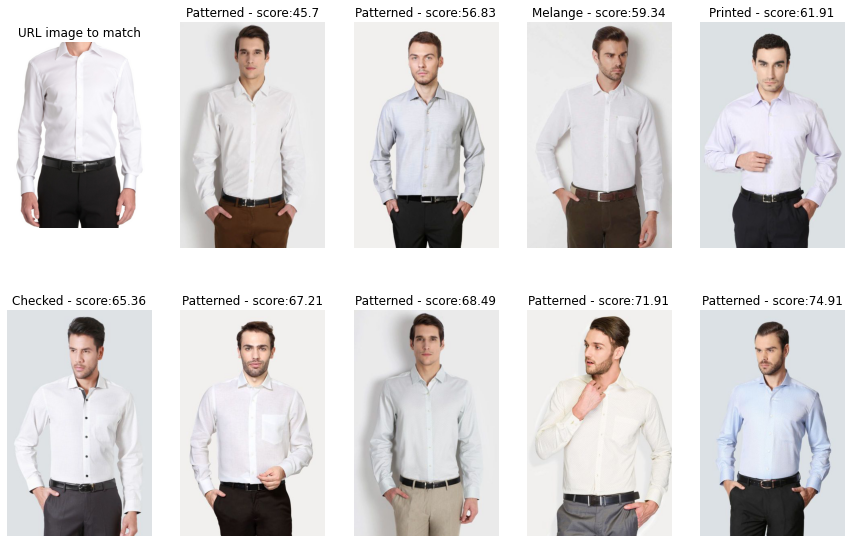

In [24]:
URL= "https://myer-media.com.au/wcsstore/MyerCatalogAssetStore/images/40/400/3311/10/1/159757840/159757840_1_720x928.jpg"

URL_search_faiss(URL, faiss_index, mapping)

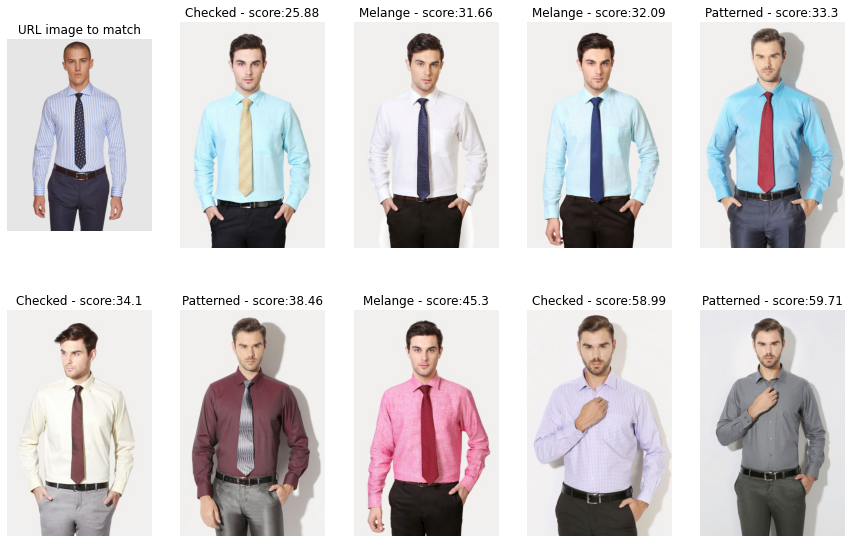

In [25]:
URL= "https://cdn.shopify.com/s/files/1/0120/0311/5089/products/PR9541.0101_1_1200x.jpg"

URL_search_faiss(URL, faiss_index, mapping)

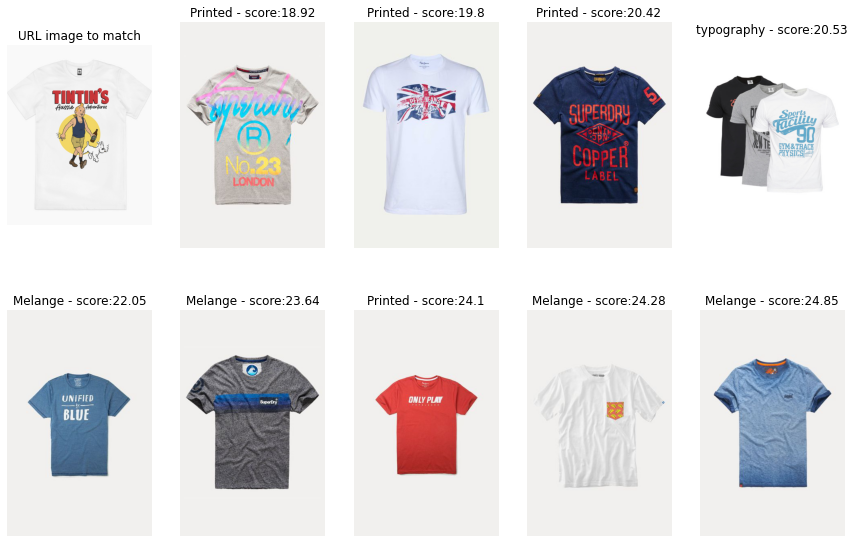

In [26]:
URL = "https://cdn.shopify.com/s/files/1/0045/7349/5389/products/white-tintins-aussie-adventures-mens-tshirt_1800x1800.jpg"

URL_search_faiss(URL, faiss_index, mapping)

We can see that even without transfer learning the pretrained keras model, we get decent results. We could further improve the model by fine tuning the pretrained model on our dataset, trying out other pretrained models and experimenting with ensembling multiple models.
Also the indexes can be fine-tuned for speed vs performance.